## Astronomy 406 "Computational Astrophysics" (Fall 2017)

### Week 13: Ordinary Differential Equations

<b>Reading:</b> notes below, as well as [$\S$17.0-17.3](https://umich.instructure.com/files/5261935/download?download_frd=1) of [Numerical Recipes](http://numerical.recipes/).

A single ordinary differential equation can sometimes be solved analytically, but when we have systems of ODEs the only way to solve them is using numerical methods.  Second-order differential equations are most common in physical applications (for examples, accelerations, waves, diffusion).  Higher-order ODEs can always be re-written as a system of coupled first-order ODEs:

$$
    {d^2\mathbf{x} \over dt^2} = f(\mathbf{x}) \quad \longrightarrow \quad
    \left\{ {d\mathbf{x} \over dt} = \mathbf{v}, \quad
            {d\mathbf{v} \over dt} = f(\mathbf{x})
    \right\}.
$$

Therefore, without loss of generality, we will consider a system of first-order ODEs:

$$
    {d\mathbf{x} \over dt} = F(t,\mathbf{x}).
$$

ODEs require boundary conditions, which are very important for the solution.  There are two types:

**initial value problem**: such as $x(t=0)=x_0$, $v(t=0)=v_0$

**two-point boundary value problem**: such as $x(t=0)=x_0$, $v(t=t_f)=0$.

We will consider the initial value problem for ODEs. Numerical solution of differential equations involves replacing derivatives (over $dt$) with finite differences (over finite interval $h$), so let's start with the Taylor expansion:

$$
   \mathbf{x}(t+h) = \mathbf{x}(t) + h {d\mathbf{x} \over dt} + {1\over 2}h^2 {d^2\mathbf{x} \over dt^2} + ... = \mathbf{x}(t) + h\, F(t,\mathbf{x}) + O(h^2).
$$

The simplest scheme is Euler's, where we take simply the first term:

**Euler scheme**: 
$\mathbf{x}(t+h) = \mathbf{x}(t) + h\, F(t,\mathbf{x}).$

A more accurate scheme is Runge-Kutta, where we calculate derivatives at mid-point:

**Runge-Kutta scheme RK2**:
$\mathbf{x}(t+h) = \mathbf{x}(t) + h\, F(t+{h\over 2},\mathbf{x}(t+{h\over 2})).$

It is accurate to second order in $h$.  In order to calculate the mid-point derivative, we need to do two steps:

$$
  \begin{cases}
    \mathbf{k}_1 = h\, F(t,\mathbf{x}(t)) \\
    \mathbf{k}_2 = h\, F(t+{h\over 2},\mathbf{x}(t)+{1\over 2}\mathbf{k}_1) \\
    \mathbf{x}(t+h) = \mathbf{x}(t) + \mathbf{k}_2
  \end{cases}
$$

The 4th-order method is even more accurate.

**Runge-Kutta scheme RK4**:

$$
  \begin{cases}
    \mathbf{k}_1 = h\, F(t,\mathbf{x}(t)) \\
    \mathbf{k}_2 = h\, F(t+{h\over 2},\mathbf{x}(t)+{1\over 2}\mathbf{k}_1) \\
    \mathbf{k}_3 = h\, F(t+{h\over 2},\mathbf{x}(t)+{1\over 2}\mathbf{k}_2) \\
    \mathbf{k}_4 = h\, F(t+h,\mathbf{x}(t)+\mathbf{k}_3) \\
    \mathbf{x}(t+h) = \mathbf{x}(t) + \frac{1}{6}(\mathbf{k}_1 + 2\mathbf{k}_2 + 2\mathbf{k}_3 + \mathbf{k}_4)
  \end{cases}
$$
<p>

### Earth orbit

Let's consider an example of integrating Earth's orbit around the Sun.  The equations are simple:

$$
    {d^2 \mathbf{r} \over dt^2} = -{G M_\odot \mathbf{r}\over r^3}
$$

and we know the correct answer - a circle in a plane.

We need to write a function $F$ that evaluates the first derivative for an array of 6 variables $\{\mathbf{r},\mathbf{v}\}$. Then we need to set initial conditions: $x = 1$ AU, $v_y = \sqrt{GM_\odot/\mathrm{AU}}$. A convenient choice of units is the unit of length of 1 astronomical unit (AU, distance to the Sun), unit of velocity is km/s, and mass of the Sun $M_\odot = 1$. We also need to set the time step.  Let's take it to be 0.01 year, and integrate for 10 years.

To control accuracy of the orbit integration, we will check conservation of energy (per unit mass):

$$
    E = {v^2 \over 2} - {G M_\odot \over r}.
$$

In [1]:
%matplotlib inline
from matplotlib import rcParams
rcParams["savefig.dpi"] = 90
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.integrate import ode

In [2]:
def f(t, y):
    # distance of Earth from Sun
    r = np.sqrt(y[0]**2 + y[1]**2 + y[2]**2)
    # acceleration of Earth from Sun
    fse = -G*Msun/r**3
    # derivates of the phase-space coordinates
    dy = np.zeros_like(y)
    dy[0] = y[3]
    dy[1] = y[4]
    dy[2] = y[5]
    dy[3] = fse*y[0]
    dy[4] = fse*y[1]
    dy[5] = fse*y[2]
    return dy
    
def Energy(y):
    r = np.sqrt(y[0]**2 + y[1]**2 + y[2]**2)
    E = 0.5*(y[3]**2 + y[4]**2 + y[5]**2) - G*Msun/r
    return E

Set initial conditions and units.

In [3]:
G = 8.89e2   # Gravitational constant in units of AU, km/s, and Msun
Msun = 1.    # mass of Sun
yr = 4.75    # unit of time in years
tf = 10./yr  # finish time

# initial positions and velocities
vE = np.sqrt(G*Msun/1.) # circular velocity of Earth
y0 = [ 1., 0., 0., 0., vE, 0. ]

# initial energy of the orbit
E0 = Energy(y0)

# time step
dt = 0.01/yr
t = 0.

Of course, there is a [routine](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.ode.html) in SciPy that does ODE integration.  Let's use it first and check our setup.

In [4]:
r = ode(f).set_integrator('dopri5')

r.set_initial_value(y0, t)

Calculate and plot the orbit.

dE = -2.96e-08
execution time = 0.044 seconds


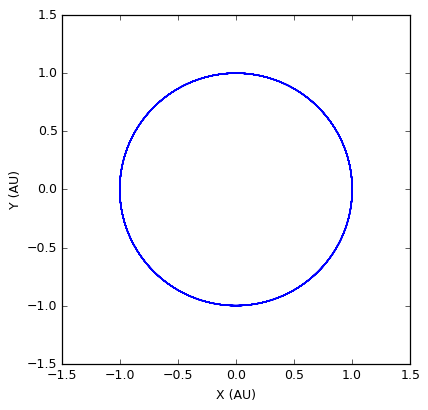

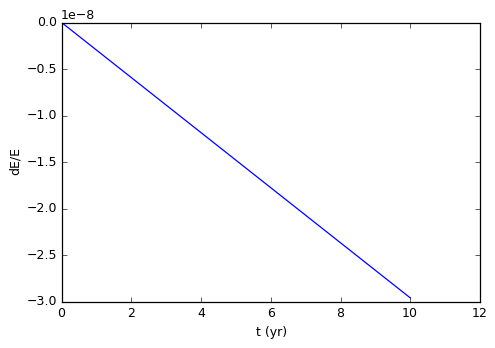

In [5]:
rt, rx, ry, re = [], [], [], []
start_time = time.time()

while t < tf:
    r.integrate(r.t + dt)
    t = r.t
    y = r.y
    dE = (Energy(y)-E0)/E0
    rt.append(t*yr); rx.append(y[0]); ry.append(y[1]); re.append(dE)

print 'dE = %.2e'%( dE )
print 'execution time = %.3f seconds'%( time.time() - start_time )
    
plt.figure(figsize=(5,5))
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.xlabel('X (AU)')
plt.ylabel('Y (AU)')
plt.plot(rx, ry, '-')
plt.show()

plt.xlabel('t (yr)')
plt.ylabel('dE/E')
plt.plot(rt, re, '-')
plt.show()

Now try the Euler and Runge-Kutta schemes.

In [6]:
def euler(t, y, h):
    y += f(t,y)*h
    return y

def rungekutta(t, y, h):
    k1 = f(t, y)*h
    k2 = f(t+0.5*h, y+0.5*k1)*h
    k3 = f(t+0.5*h, y+0.5*k2)*h
    k4 = f(t+h, y+k3)*h
    y += (k1+2*k2+2*k3+k4)/6.
    return y

The first-order Euler scheme is inaccurate in this case, as you can see by the spiraling orbit.

dE = -6.68e-01
execution time = 0.012 seconds


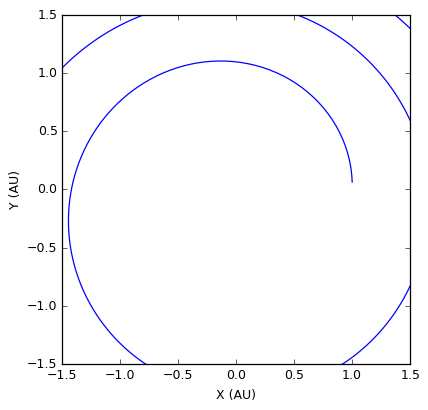

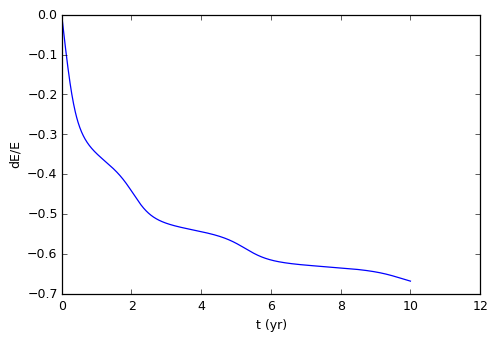

In [7]:
y = y0
t = 0.
rt, rx, ry, re = [], [], [], []
start_time = time.time()

dt = 1e-2 / yr

while t < tf:
    y = euler(t, y, dt)
    t += dt
    dE = (Energy(y)-E0)/E0
    rt.append(t*yr); rx.append(y[0]); ry.append(y[1]); re.append(dE)
    
print 'dE = %.2e'%( dE )
print 'execution time = %.3f seconds'%( time.time() - start_time )

plt.figure(figsize=(5,5))
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.xlabel('X (AU)')
plt.ylabel('Y (AU)')
plt.plot(rx, ry, '-')
plt.show()

plt.xlabel('t (yr)')
plt.ylabel('dE/E')
plt.plot(rt, re, '-')
plt.show()

The Runge-Kutta scheme is better:

dE = 1.79e-03
execution time = 0.012 seconds


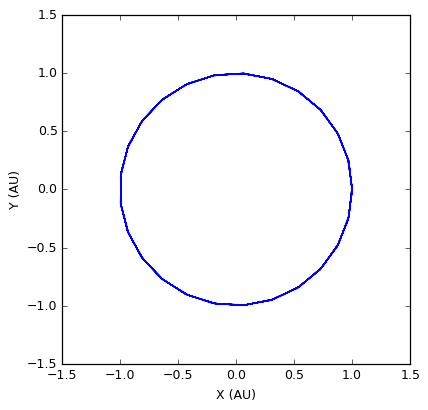

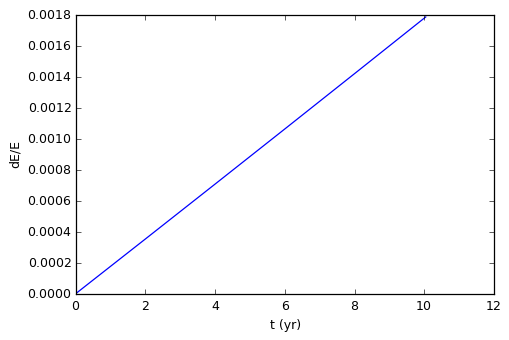

In [8]:
y = y0
t = 0.
rt, rx, ry, re = [], [], [], []
start_time = time.time()

dt = 0.04/yr

while t < tf:
    y = rungekutta(t, y, dt)
    t += dt
    dE = (Energy(y)-E0)/E0
    rt.append(t*yr); rx.append(y[0]); ry.append(y[1]); re.append(dE)
    
print 'dE = %.2e'%( dE )
print 'execution time = %.3f seconds'%( time.time() - start_time )
    
plt.figure(figsize=(5,5))
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.xlabel('X (AU)')
plt.ylabel('Y (AU)')
plt.plot(rx, ry, '-')
plt.show()

plt.xlabel('t (yr)')
plt.ylabel('dE/E')
plt.plot(rt, re, '-')
plt.show()

Calculation of orbits, in particular, is very efficient and accurate with an ingeneous method called **leap-frog**.  It alternates advancing positions and velocities.  Its important property is being time-reversible - we can integrate the equations backward in time and arrive (roughly) at the initial condition.  Other algorithms cannot do that, they accumulate error over time.  For leap-frog, the error is not steadily increasing but fluctuating.

This method is restricted to 2nd-order ODE.  It explicitly splits the array of variables into two equal parts: "coordinates" and their first derivatives ("velocities").

**Leap-frog scheme**:
$$
  \begin{cases}
    \mathbf{v}_{n+\frac{1}{2}} = \mathbf{v}_{n} + f(\mathbf{x}_{n})\, {h\over 2} 
      \quad \mathrm{(kick~step)}\\
    \mathbf{x}_{n+1} = \mathbf{x}_{n} + \mathbf{v}_{n+\frac{1}{2}}\, h
      \quad \mathrm{(drift~step)}\\
    \mathbf{v}_{n+1} = \mathbf{v}_{n+\frac{1}{2}} + f(\mathbf{x}_{n+1})\, {h\over 2}
      \quad \mathrm{(kick~step)}
  \end{cases}
$$

In [9]:
def leapfrog(t, y, h):
    # kick
    dy = f(t,y)
    for i in range(3,6):
        y[i] += dy[i]*h/2.
    # drift
    for i in range(0,3):
        y[i] += y[i+3]*h
    # kick
    dy = f(t,y)
    for i in range(3,6):
        y[i] += dy[i]*h/2.
    return y

Calculate the orbit with leap-frog:

dE = -2.00e-11
execution time = 0.084 seconds


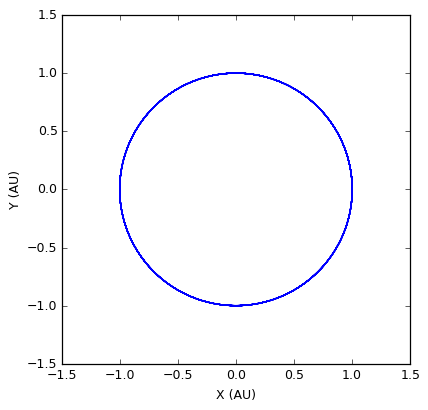

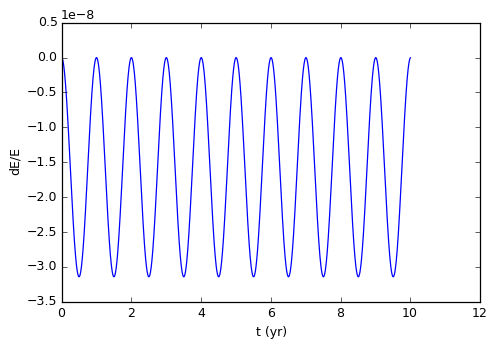

In [10]:
y = y0
t = 0.
rt, rx, ry, re = [], [], [], []
start_time = time.time()

dt = 0.003 / yr

while t < tf:    
    y = leapfrog(t, y, dt)
    t += dt
    dE = (Energy(y)-E0)/E0
    rt.append(t*yr); rx.append(y[0]); ry.append(y[1]); re.append(dE)

print 'dE = %.2e'%( dE )   #np.amax(abs(dE))
print 'execution time = %.3f seconds'%( time.time() - start_time )
    
plt.figure(figsize=(5,5))
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.xlabel('X (AU)')
plt.ylabel('Y (AU)')
plt.plot(rx, ry, '-')
plt.show()

plt.xlabel('t (yr)')
plt.ylabel('dE/E')
plt.plot(rt, re, '-')
plt.show()

**Exercise 1**: This was not a completely fair comparison of the accuracy of the various methods. At the same step $h$, the Euler method made the one step, the Runge-Kutta made 4 steps, and the SciPy routine made an unknown (likely, significantly larger) number of steps.

(a)
Find the values of the step <tt>dt</tt> that match the accuracy of the SciPy routine for each of the Euler, Runge-Kutta, and leap-frog methods. Compare the execution times.

(b)
Find the values of the step <tt>dt</tt> that match the execution time of the SciPy routine for each of the Euler, Runge-Kutta, and leap-frog methods. Compare the accuracy.

When changing h to get a dt with matching accuracy (dE = 5E-3), the execution time was... <br />
Euler: 12.454 seconds<br />
Runge-Kutta: 0.010 seconds<br />
Leap-frog: 0.005 seconds<br />

When changing h to get a dt with execution time (0.017 seconds), the accuracy dE was...<br />
Euler: -6.62e-01<br />
Runge-Kutta: -2.33e-03<br />
Leap-frog: -4.26e-03<br />

### Spacecraft

Now let's do a more interesting problem. If we want to send a spacecraft to the outer reaches of the Solar System and beyond, we need large enough launch velocity to overcome not just Earth gravity, but also Sun's gravity. The escape speed from the Earth surface is $\sqrt{2G M_E\, /\, R_E} = 11.2$ km/s, but the escape speed from the Sun is $\sqrt{2G M_\odot\, /\, \mathrm{AU}} = 42.2$ km/s.  Fuel cost scales as $v^2$, and currently the three-stage rockets are barely able to lift a small spacecraft to the near-Earth orbit.  So launching rockets with the speed of 42 km/s is impractical.  

Luckily, there is a wonderful technique called [*gravity assist*](https://en.wikipedia.org/wiki/Gravity_assist), where the spacecraft has a close encounter with another massive body (for example, a planet) and gains additional speed from it.  We will consider a gravity assist from Jupiter, the most massive body after the Sun, and try to fly out of the Solar System.

Now we will need to integrate simultaneously the orbits of Earth, Jupiter, and spacecraft.  We will therefore have $3\times 6 = 18$ variables in array $y$.

In [11]:
def f(t, y):
    # position of spacecraft
    xs = y[0]; ys = y[1]; zs = y[2]
    # position of Earth
    xe = y[6]; ye = y[7]; ze = y[8]
    # position of Jupiter
    xj = y[12]; yj = y[13]; zj = y[14]

    # relative distances of spacecraft from Earth and Jupiter
    rs = np.sqrt(xs**2 + ys**2 + zs**2)
    rse = np.sqrt((xs-xe)**2 + (ys-ye)**2 + (zs-ze)**2)
    rsj = np.sqrt((xs-xj)**2 + (ys-yj)**2 + (zs-zj)**2)

    # acceleration of spacecraft from Sun, Earth, and Jupiter
    fs = -G*Msun/rs**3
    fse = -G*ME/rse**3
    fsj = -G*MJ/rsj**3

    # derivates of the phase-space coordinates of the spacecraft
    dy = np.zeros_like(y)
    dy[0] = y[3]; dy[1] = y[4]; dy[2] = y[5]
    dy[3] = fs*xs + fse*(xs-xe) + fsj*(xs-xj)
    dy[4] = fs*ys + fse*(ys-ye) + fsj*(ys-yj)
    dy[5] = fs*zs + fse*(zs-ze) + fsj*(zs-zj)
      
    # derivates of the phase-space coordinates of Earth
    dy[6] = y[9]; dy[7] = y[10]; dy[8] = y[11]
    re = np.sqrt(xe**2 + ye**2 + ze**2)
    rej = np.sqrt((xe-xj)**2 + (ye-yj)**2 + (ze-zj)**2)    
    fe = -G*Msun/re**3
    fej = -G*MJ/rej**3
    dy[9]  = fe*xe + fej*(xe-xj)
    dy[10] = fe*ye + fej*(ye-yj)
    dy[11] = fe*ze + fej*(ze-zj)

    # derivates of the phase-space coordinates of Jupiter
    dy[12] = y[15]; dy[13] = y[16]; dy[14] = y[17]
    rj = np.sqrt(xj**2 + yj**2 + zj**2)
    fj = -G*Msun/rj**3
    fje = -G*ME/rej**3
    dy[15] = fj*xj + fje*(xj-xe)
    dy[16] = fj*yj + fje*(yj-ye)
    dy[17] = fj*zj + fje*(zj-ze)
    return dy

def Energy(y):
    satellite_energy = True  # check energy conservation for satellite or Earth
    xs = y[0]; ys = y[1]; zs = y[2]
    xe = y[6]; ye = y[7]; ze = y[8]
    xj = y[12]; yj = y[13]; zj = y[14]
    if satellite_energy:
        rs = np.sqrt(xs**2 + ys**2 + zs**2)
        rse = np.sqrt((xs-xe)**2 + (ys-ye)**2 + (zs-ze)**2)
        rsj = np.sqrt((xs-xj)**2 + (ys-yj)**2 + (zs-zj)**2)
        E = 0.5*(y[3]**2 + y[4]**2 + y[5]**2) - G*Msun/rs - G*ME/rse - G*MJ/rsj
    else:
        re = np.sqrt(xe**2 + ye**2 + ze**2)
        rej = np.sqrt((xe-xj)**2 + (ye-yj)**2 + (ze-zj)**2)
        E = 0.5*(y[9]**2 + y[10]**2 + y[11]**2) - G*Msun/re - G*MJ/rej
    return E

Also, the characteristic timescales (orbital periods) of the three objects are different, so we will need to use adaptive timestep.  There are many suggestions for managing the size of the timestep in Numerical Recipes [$\S$17.2-17.3](https://umich.instructure.com/files/5261935/download?download_frd=1), including comparison with a higher-order Runge-Kutta scheme RK5, and our familiar Richardson extrapolation.  We will take an approach best suitable for orbit calculation, where the timestep is set to be a multiple of $\sqrt{|\mathbf{r}| \,/\, |\ddot{\mathbf{r}}|}$.  To retain the nice **symplectic** (time-reversible) property of the leap-frog method, a new timestep must be commensurate with the old timestep.  That is, we increase or decrease $h$ only by a factor 2 (or other integer number).

Important: Truncation error!!! Why we are doing adaptive timestep partly.

In [12]:
hfactor = 1.e-4

def timestep(y, dy, h):
    pos = np.sqrt(y[0]**2 + y[1]**2 + y[2]**2)
    acc = np.sqrt(dy[3]**2 + dy[4]**2 + dy[5]**2)
    hh = hfactor*np.sqrt(pos/acc)    #More important line to get right units for the time step 
    hmin = 1.e-9/yr
    
    #Some important checks to prevent infinite loops (along with print statement to double check)
    if hh < h/2. and h > hmin:
        print "hh=%.2e < h=%.2e r=%.6f"% (hh*yr, h*yr, pos)
        h /= 2.
    if hh > 2.*h:
        print "hh=%.2e > h=%.2e r=%.6f"% (hh*yr, h*yr, pos)
        h *= 2.
    if(h < hmin):
        h = hmin
    return h

Revised implementation of the leap-frog and Runge-Kutta methods for 18 variables:

In [13]:
def leapfrog(t, y, h):
    poslist = [ 0, 1, 2, 6, 7, 8, 12, 13, 14 ]
    vellist = [ 3, 4, 5, 9, 10, 11, 15, 16, 17 ]
    # kick
    dy = f(t,y)
    for i in vellist:
        y[i] += dy[i]*h/2.
    # drift
    for i in poslist:
        y[i] += y[i+3]*h
    # kick
    dy = f(t,y)
    for i in vellist:
        y[i] += dy[i]*h/2.
    # estimate next timestep
    return y, timestep(y, dy, h)

def rungekutta(t, y, h):
    k1 = f(t, y)*h
    k2 = f(t+0.5*h, y+0.5*k1)*h
    k3 = f(t+0.5*h, y+0.5*k2)*h
    k4 = f(t+h, y+k3)*h
    y += (k1+2*k2+2*k3+k4)/6.
    return y, timestep(y, k4/h, h)

Physical properties and initial conditions for the satellite, Earth, and Jupiter:

In [64]:
G = 8.89e2   # Gravitational constant in units of AU, km/s, and Msun
Msun = 1.    # mass of Sun
ME = 3.0e-6  # mass of Earth
RE = 4.25e-5 # radius of Earth
MJ = 9.5e-4  # mass of Jupiter
rJ = 5.2     # radius of Jupiter orbit
yr = 4.75    # unit of time in years
tf = 10./yr  # finish time

# initial positions and velocities
vx = 10.5
vy = 11.0338
cosa = 0.52
sina = np.sqrt(1.-cosa**2)
vE = np.sqrt(G*Msun/1.)
vJ = np.sqrt(G*Msun/rJ)
y0 = [ 1.+RE,   0.,      0., vx,       vy+vE,   0.,\
      1.,      0.,      0., 0.,       vE,      0.,\
      rJ*cosa, rJ*sina, 0., -vJ*sina, vJ*cosa, 0. ]
E0 = Energy(y)

Calculate and plot the orbit with leap-frog, Runge-Kutta, or Scipy's routine:

max dE =  39.9541719844
dE = -1.11e-01
execution time = 0.188 seconds


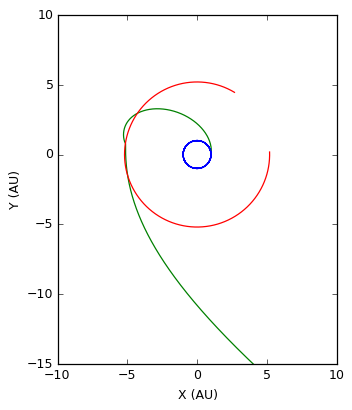

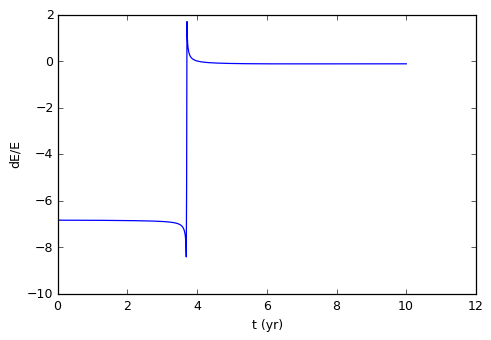

In [66]:
t = 0.
y = y0
rt, re, rxs, rys, rzs, rxe, rye, rze, rxj, ryj, rzj = [], [], [], [], [], [], [], [], [], [], []
start_time = time.time()

use_scipy_integrator = True

if use_scipy_integrator:
    r = ode(f).set_integrator('dopri5', atol=1e-6, rtol=1e-6)
    r.set_initial_value(y, t)
    dt = 1.e-2/yr
else:
    dt = 1.e-6/yr

while t < tf:
    if use_scipy_integrator:
        r.integrate(r.t + dt)
        t = r.t
        y = r.y
    else:
        y, h = leapfrog(t, y, dt)
        #y, h = rungekutta(t, y, dt)
        t += dt
        dt = h  #The adaptive timestep (e.g. in leapfrog) is used to change the time step
    dE = (Energy(y)-E0)/E0
    rt.append(t*yr); re.append(dE)
    rxs.append(y[0]); rys.append(y[1]); rzs.append(y[2])
    rxe.append(y[6]); rye.append(y[7]); rze.append(y[8])
    rxj.append(y[12]); ryj.append(y[13]); rzj.append(y[14])

print 'max dE = ', max(re)*E0
print 'dE = %.2e'%( dE )
print 'execution time = %.3f seconds'%( time.time() - start_time )
    
plt.figure(figsize=(4,5))
plt.xlim(-10, 10)
plt.ylim(-15, 10)
plt.xlabel('X (AU)')
#plt.ylabel('Z (au)')
#plt.plot(rxs, rzs, 'g-')
#plt.plot(rxe, rze, 'b--')
#plt.plot(rxj, rzj, 'r-')
plt.ylabel('Y (AU)')
plt.plot(rxs, rys, 'g-')
plt.plot(rxe, rye, 'b--')
plt.plot(rxj, ryj, 'r-')
plt.show()

plt.xlabel('t (yr)')
plt.ylabel('dE/E')
plt.plot(rt, re, '-')
plt.show()

hh=4.11e-07 < h=1.00e-06 r=1.000045
hh=1.01e-06 > h=5.00e-07 r=1.000091
hh=2.02e-06 > h=1.00e-06 r=1.000157
hh=4.03e-06 > h=2.00e-06 r=1.000287
hh=8.03e-06 > h=4.00e-06 r=1.000577
hh=1.60e-05 > h=8.00e-06 r=1.007162
hh=3.20e-05 > h=1.60e-05 r=1.591925
hh=6.40e-05 > h=3.20e-05 r=2.526778
hh=1.28e-04 > h=6.40e-05 r=4.011290
hh=6.40e-05 < h=1.28e-04 r=5.235726
hh=3.19e-05 < h=6.40e-05 r=5.219825
hh=1.60e-05 < h=3.20e-05 r=5.211485
hh=7.99e-06 < h=1.60e-05 r=5.206569
hh=3.99e-06 < h=8.00e-06 r=5.203176
hh=8.01e-06 > h=4.00e-06 r=5.193898
hh=1.60e-05 > h=8.00e-06 r=5.190384
hh=3.20e-05 > h=1.60e-05 r=5.185016
hh=6.40e-05 > h=3.20e-05 r=5.176201
hh=1.28e-04 > h=6.40e-05 r=5.161237
hh=2.56e-04 > h=1.28e-04 r=6.382007
hh=5.12e-04 > h=2.56e-04 r=10.122367
hh=1.02e-03 > h=5.12e-04 r=16.053200
max dE =  119.697444307
dE = -1.79e-01
execution time = 9.335 seconds


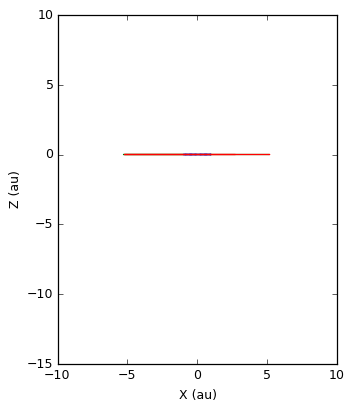

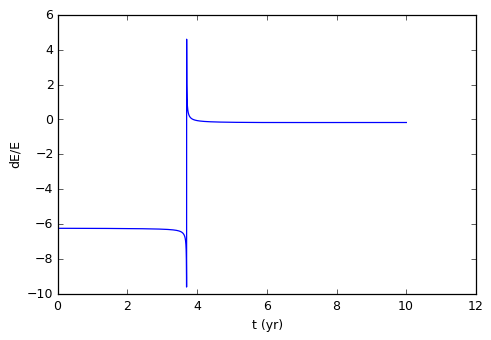

In [55]:
t = 0.
y = y0
rt, re, rxs, rys, rzs, rxe, rye, rze, rxj, ryj, rzj = [], [], [], [], [], [], [], [], [], [], []
start_time = time.time()

use_scipy_integrator = False

if use_scipy_integrator:
    r = ode(f).set_integrator('dopri5', atol=1e-6, rtol=1e-6)
    r.set_initial_value(y, t)
    dt = 1.e-2/yr
else:
    dt = 1.e-6/yr

while t < tf:
    if use_scipy_integrator:
        r.integrate(r.t + dt)
        t = r.t
        y = r.y
    else:
        #y, h = leapfrog(t, y, dt)
        y, h = rungekutta(t, y, dt)
        t += dt
        dt = h  #The adaptive timestep (e.g. in leapfrog) is used to change the time step
    dE = (Energy(y)-E0)/E0
    rt.append(t*yr); re.append(dE)
    rxs.append(y[0]); rys.append(y[1]); rzs.append(y[2])
    rxe.append(y[6]); rye.append(y[7]); rze.append(y[8])
    rxj.append(y[12]); ryj.append(y[13]); rzj.append(y[14])

print 'max dE = ', max(re)*E0
print 'dE = %.2e'%( dE )
print 'execution time = %.3f seconds'%( time.time() - start_time )
    
plt.figure(figsize=(4,5))
plt.xlim(-10, 10)
plt.ylim(-15, 10)
plt.xlabel('X (au)')
plt.ylabel('Z (au)')
plt.plot(rxs, rzs, 'g-')
plt.plot(rxe, rze, 'b--')
plt.plot(rxj, rzj, 'r-')
plt.show()

plt.xlabel('t (yr)')
plt.ylabel('dE/E')
plt.plot(rt, re, '-')
plt.show()

**Exercise 2**: Find the timestep for the leapfrog and Runge-Kutta schemes that correctly captures gravity assist. Calculate the maximum energy change of the orbit. Check the excursion of the orbit into Z direction outside the plane.

Timestep starts at 1E-4 for leap-frog and 3E-5 for runge-kutta (graphically seen when orbit is bound). The maximum energy for this orbit respectively for scipy, runge-kutta, leap-frog is dE/E = 40, 146, 119. Finally, none go into the Z-direction outside the plane.

**Exercise 3**: Add Mars as another mass component. Investigate stability of the satellite orbit. Mars's mass is 3.2e-7 solar masses, orbital radius is 1.5 AU. How would the result change of Mars were 100 times more massive?  1000 times more massive?